In [2]:
import keras
#import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
tf.config.run_functions_eagerly(True)

from keras.models import Sequential
from keras.layers import Dense, InputLayer, Dropout, Conv2D, MaxPooling2D, Flatten, Embedding, LSTM, GRU, RNN
from keras.utils import to_categorical, set_random_seed, pad_sequences
from keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [16]:
# Read the data file into a Pandas DataFrame
import pandas as pd
df = pd.read_csv('/Users/blankajarmoszko/PycharmProjects/thesis/data/df_cleaned.csv')

In [17]:
df.head()

,title,reviewer_name,num_reviews,num_followers,star_rating,review_text,num_likes,num_comments,sentiment,cleaned_text
0,The Stolen Heir,Emily May,"2,031",310k,4.0,Not quite The Cruel Prince but I enjoyed this ...,"1,206",3.0,1,"quit,cruel,princ,enjoy,loti,love,back,world,lo..."
1,The Stolen Heir,jessica,"2,563",42.2k,4.0,hmm. i didnt obsess over this one like i did w...,654,0.0,1,"hmm,didnt,obsess,one,like,origin,trilogywhil,e..."
2,The Stolen Heir,katia,306,526,3.0,"3.5 ★oak was a disappointment, but suren!! i l...","1,233",0.0,0,"oak,disappoint,suren,love,much,cant,pretend,do..."
3,The Stolen Heir,madeline,111,18,3.0,Every single mention of Oak’s hooves was a jum...,"1,707",4.0,0,"everi,singl,mention,oak,hoov,jumpscar"
4,The Stolen Heir,Haley pham,81,143k,4.0,4.5 stars star fairy_light_skin_tone face_h...,"1,432",0.0,1,"star,star,fairy_light_skin_ton,face_holding_ba..."


In [18]:
df.head()

,title,reviewer_name,num_reviews,num_followers,star_rating,review_text,num_likes,num_comments,sentiment,cleaned_text
0,The Stolen Heir,Emily May,"2,031",310k,4.0,Not quite The Cruel Prince but I enjoyed this ...,"1,206",3.0,1,"quit,cruel,princ,enjoy,loti,love,back,world,lo..."
1,The Stolen Heir,jessica,"2,563",42.2k,4.0,hmm. i didnt obsess over this one like i did w...,654,0.0,1,"hmm,didnt,obsess,one,like,origin,trilogywhil,e..."
2,The Stolen Heir,katia,306,526,3.0,"3.5 ★oak was a disappointment, but suren!! i l...","1,233",0.0,0,"oak,disappoint,suren,love,much,cant,pretend,do..."
3,The Stolen Heir,madeline,111,18,3.0,Every single mention of Oak’s hooves was a jum...,"1,707",4.0,0,"everi,singl,mention,oak,hoov,jumpscar"
4,The Stolen Heir,Haley pham,81,143k,4.0,4.5 stars star fairy_light_skin_tone face_h...,"1,432",0.0,1,"star,star,fairy_light_skin_ton,face_holding_ba..."


In [19]:
# Drop rows with NaN values in the 'cleaned_text' column
df = df.dropna(subset=['cleaned_text'])

# Reset index after removing rows
df.reset_index(drop=True, inplace=True)

In [9]:
def convert_to_list(text):
    return text.split(',')
df["cleaned_text"] = df["cleaned_text"].apply(convert_to_list)

In [20]:
df.head()

,title,reviewer_name,num_reviews,num_followers,star_rating,review_text,num_likes,num_comments,sentiment,cleaned_text
0,The Stolen Heir,Emily May,"2,031",310k,4.0,Not quite The Cruel Prince but I enjoyed this ...,"1,206",3.0,1,"quit,cruel,princ,enjoy,loti,love,back,world,lo..."
1,The Stolen Heir,jessica,"2,563",42.2k,4.0,hmm. i didnt obsess over this one like i did w...,654,0.0,1,"hmm,didnt,obsess,one,like,origin,trilogywhil,e..."
2,The Stolen Heir,katia,306,526,3.0,"3.5 ★oak was a disappointment, but suren!! i l...","1,233",0.0,0,"oak,disappoint,suren,love,much,cant,pretend,do..."
3,The Stolen Heir,madeline,111,18,3.0,Every single mention of Oak’s hooves was a jum...,"1,707",4.0,0,"everi,singl,mention,oak,hoov,jumpscar"
4,The Stolen Heir,Haley pham,81,143k,4.0,4.5 stars star fairy_light_skin_tone face_h...,"1,432",0.0,1,"star,star,fairy_light_skin_ton,face_holding_ba..."


## RNN

In [21]:
import keras
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
tf.config.run_functions_eagerly(True)
from tensorflow.keras.preprocessing.text import Tokenizer

from keras.models import Sequential
from keras.layers import Dense, InputLayer, Dropout, Conv2D, MaxPooling2D, Flatten, Embedding, LSTM, GRU, RNN
from keras.utils import to_categorical, set_random_seed, pad_sequences
from keras.callbacks import EarlyStopping
from keras.optimizers.legacy import Adam

from sklearn.metrics import accuracy_score, confusion_matrix

## Data Processing

In [22]:
# Get the minimum and the maximum length of reviews
max_length = df['cleaned_text'].apply(lambda x: len(x) if isinstance(x, list) else 0).max()
print(f"The maximum length of lists in the column is: {max_length}")
min_length = df['cleaned_text'].apply(lambda x: len(x) if isinstance(x, list) else 0).min()
print(f"The minimum length of lists in the column is: {min_length}")

The maximum length of lists in the column is: 0
The minimum length of lists in the column is: 0


In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
import pandas as pd

# Sample DataFrame df with 'cleaned_text' column
# df = pd.DataFrame({'cleaned_text': cleaned_text_list, 'label': label_list})

# Set the maximum number of words to keep
max_words = 1000

# Create a Tokenizer instance with specified parameters
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")

# Fit the tokenizer on the text data
tokenizer.fit_on_texts(df['cleaned_text'])

# Convert text to sequences of integers
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])

# Get the word index mapping
word_index = tokenizer.word_index

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text'], df['sentiment'], test_size=0.2, random_state=42)

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=max_words)

# Fit and transform the training data to TF-IDF vectors
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train).toarray()

# Transform the testing data to TF-IDF vectors
X_test_tfidf = tfidf_vectorizer.transform(X_test).toarray()

# Print the shapes of the TF-IDF vectors
print("Shape of X_train_tfidf:", X_train_tfidf.shape)
print("Shape of X_test_tfidf:", X_test_tfidf.shape)


Shape of X_train_tfidf: (37268, 1000)
Shape of X_test_tfidf: (9317, 1000)


In [24]:
df.head()

,title,reviewer_name,num_reviews,num_followers,star_rating,review_text,num_likes,num_comments,sentiment,cleaned_text,sequences
0,The Stolen Heir,Emily May,"2,031",310k,4.0,Not quite The Cruel Prince but I enjoyed this ...,"1,206",3.0,1,"[quit, cruel, princ, enjoy, loti, love, back, ...","[163, 1, 1, 49, 1, 6, 69, 36, 6, 33, 43, 1, 1,..."
1,The Stolen Heir,jessica,"2,563",42.2k,4.0,hmm. i didnt obsess over this one like i did w...,654,0.0,1,"[hmm, didnt, obsess, one, like, origin, trilog...","[1, 39, 771, 5, 4, 393, 1, 49, 8, 33, 97, 62, ..."
2,The Stolen Heir,katia,306,526,3.0,"3.5 ★oak was a disappointment, but suren!! i l...","1,233",0.0,0,"[oak, disappoint, suren, love, much, cant, pre...","[1, 358, 1, 6, 11, 91, 1, 28, 4, 427, 1, 1, 93..."
3,The Stolen Heir,madeline,111,18,3.0,Every single mention of Oak’s hooves was a jum...,"1,707",4.0,0,"[everi, singl, mention, oak, hoov, jumpscar]","[71, 423, 250, 1, 1, 1]"
4,The Stolen Heir,Haley pham,81,143k,4.0,4.5 stars star fairy_light_skin_tone face_h...,"1,432",0.0,1,"[star, star, fairy_light_skin_ton, face_holdin...","[46, 46, 1, 1]"


In [25]:
# # Split the dataset into training and testing sets
# x_train_pd, x_test_pd, y_train_pd, y_test_pd = train_test_split(df['sequences'], df['sentiment'], test_size=0.2, random_state=42)
# x_train = X_train_tfidf.values
# x_test = X_test_tfidf.values
# y_train = y_train.values
# y_test = y_test.values

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [26]:
set_random_seed(0)
max_words = 100
y_train_cat = to_categorical(y_train)

X_train = pad_sequences(X_train_tfidf, maxlen=max_words)
X_test = pad_sequences(X_test_tfidf, maxlen=max_words)

print(X_train.shape)

(37268, 100)


### Simple Model

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Embedding, Dense, Dropout

# Define the parameters
vocabulary_size = 1000
embedding_size = 50

# Create the model
model = Sequential()
model.add(InputLayer(input_shape=(max_words,)))
model.add(Embedding(vocabulary_size, embedding_size))
model.add(Dense(50, activation='relu'))  # Replace LSTM with Dense
model.add(Dense(20, activation='relu'))  # Replace LSTM with Dense
 # Replace LSTM with Dense
model.add(Dense(5, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

# Print model summary
print(model.summary())


/Users/blankajarmoszko/PycharmProjects/thesis/venv/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 50)        │        50,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100, 50)        │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100, 20)        │         1,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100, 5)         │           105 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 5)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100, 3)         │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,693 (209.74 KB)

 Trainable params: 53,693 (209.74 KB)

 Non-trainable params: 0 (0.00 B)

None


In [31]:
from sklearn.metrics import classification_report
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(patience=5, monitor='val_loss')

# Train the model
history = model.fit(X_train, y_train, validation_split=0.1, epochs=50, batch_size=256, callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Print classification report
predictions = model.predict_classes(X_test)
print(classification_report(y_test, predictions))

Epoch 1/50


/Users/blankajarmoszko/PycharmProjects/thesis/venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


ValueError: Arguments `target` and `output` must have the same shape up until the last dimension: target.shape=(256, 1), output.shape=(256, 100, 3)

In [28]:
set_random_seed(0)
model.compile(loss='categorical_crossentropy', 
             optimizer='adam', # rmsprop
             metrics=['accuracy'])

batch_size = 256
num_epochs = 50

early = EarlyStopping('val_loss', patience = 15)

history = model.fit(X_train, y_train_cat, validation_split=0.1, batch_size=batch_size, epochs=num_epochs, callbacks=early)

Epoch 1/50


/Users/blankajarmoszko/PycharmProjects/thesis/venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(256, 3), output.shape=(256, 100, 3)

In [30]:
y_train_cat.shape

(37268, 3)

### Model Tunning

In [32]:
def model_builder(hp):
    model = Sequential()
    
    vocabulary_size = 1000
    embedding_size = 50
    max_words = 50  # Assuming you have a max_words variable

    model.add(InputLayer(input_shape=(max_words,)))
    model.add(Embedding(vocabulary_size, embedding_size))

    hp_activation = hp.Choice('activation', values=['relu', 'tanh'])
    hp_units_1 = hp.Int('units_1', min_value=10, max_value=100, step=10)
    hp_units_2 = hp.Int('units_2', min_value=10, max_value=100, step=10)
    hp_units_3 = hp.Int('units_3', min_value=10, max_value=100, step=10)
    hp_units_4 = hp.Int('units_4', min_value=10, max_value=100, step=10)

    model.add(LSTM(units=hp_units_1, activation=hp_activation, return_sequences=True))
    # model.add(LSTM(units=hp_units_2, activation=hp_activation, return_sequences=True))
    # model.add(LSTM(units=hp_units_3, activation=hp_activation, return_sequences=True))
    model.add(LSTM(units=hp_units_4, activation=hp_activation))
    
    model.add(Dense(5, activation='relu'))
    model.add(Dropout(0.2)) 
    model.add(Dense(3, activation='softmax'))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    optimizer = Adam(learning_rate=hp_learning_rate)
    model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

    return model

In [33]:
import keras_tuner as kt

tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='dir',
                     project_name='x')

Reloading Tuner from dir/x/tuner0.json


In [35]:
stop_early = EarlyStopping(monitor='val_loss', patience=3)
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

Trial 26 Complete [00h 05m 27s]
val_accuracy: 0.38985779881477356

Best val_accuracy So Far: 0.5681513547897339
Total elapsed time: 01h 56m 34s


In [46]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

{'activation': 'tanh',
 'units_1': 20,
 'units_2': 50,
 'units_3': 80,
 'units_4': 40,
 'learning_rate': 0.001,
 'tuner/epochs': 4,
 'tuner/initial_epoch': 2,
 'tuner/bracket': 2,
 'tuner/round': 1,
 'tuner/trial_id': '0002'}

In [38]:
# fit the model based on best params
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2,
                    callbacks=[stop_early])

Epoch 1/50
  2/932 [..............................] - ETA: 56s - loss: 1.0990 - accuracy: 0.2656 

/Users/blankajarmoszko/PycharmProjects/Selenium_trial/venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


932/932 [==============================] - 64s 68ms/step - loss: 0.9943 - accuracy: 0.4722 - val_loss: 0.9275 - val_accuracy: 0.5376
Epoch 2/50
932/932 [==============================] - 65s 70ms/step - loss: 0.9274 - accuracy: 0.5242 - val_loss: 0.9064 - val_accuracy: 0.5468
Epoch 3/50
932/932 [==============================] - 65s 70ms/step - loss: 0.9065 - accuracy: 0.5542 - val_loss: 0.9077 - val_accuracy: 0.5460
Epoch 4/50
932/932 [==============================] - 66s 71ms/step - loss: 0.8881 - accuracy: 0.5640 - val_loss: 0.8993 - val_accuracy: 0.5569
Epoch 5/50
932/932 [==============================] - 66s 70ms/step - loss: 0.8727 - accuracy: 0.5708 - val_loss: 0.9017 - val_accuracy: 0.5553
Epoch 6/50
932/932 [==============================] - 67s 72ms/step - loss: 0.8637 - accuracy: 0.5797 - val_loss: 0.9032 - val_accuracy: 0.5555
Epoch 7/50
932/932 [==============================] - 66s 71ms/step - loss: 0.8538 - accuracy: 0.5833 - val_loss: 0.9105 - val_accuracy: 0.5566


In [41]:
y_pred = np.argmax(model.predict(X_test), axis=1)

print(accuracy_score(y_pred, y_test))
print(confusion_matrix(y_pred, y_test))

y_train_pred = np.argmax(model.predict(X_train), axis=1)
print(accuracy_score(y_train_pred, y_train))

# Changing max_words for longer sequences and vocabulary size for more different words
# That makes the network run for much much longer

  5/292 [..............................] - ETA: 7s

/Users/blankajarmoszko/PycharmProjects/Selenium_trial/venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


292/292 [==============================] - 8s 26ms/step
0.556509606096383
[[1566  531  324]
 [ 799 1196  862]
 [ 402 1214 2423]]


In [43]:
y_train_pred = np.argmax(model.predict(X_train), axis=1)
print(accuracy_score(y_train_pred, y_train))

   5/1165 [..............................] - ETA: 30s

/Users/blankajarmoszko/PycharmProjects/Selenium_trial/venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1165/1165 [==============================] - 30s 26ms/step
0.6033594504668884


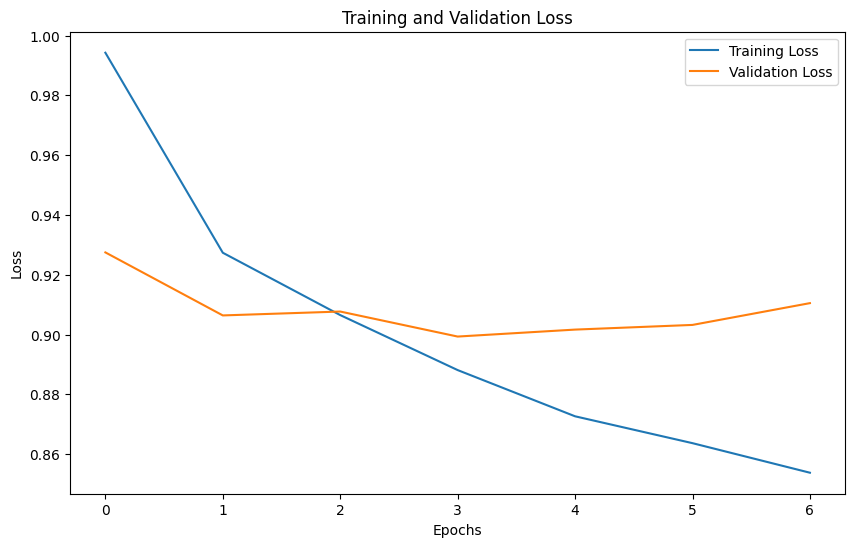

In [39]:
# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


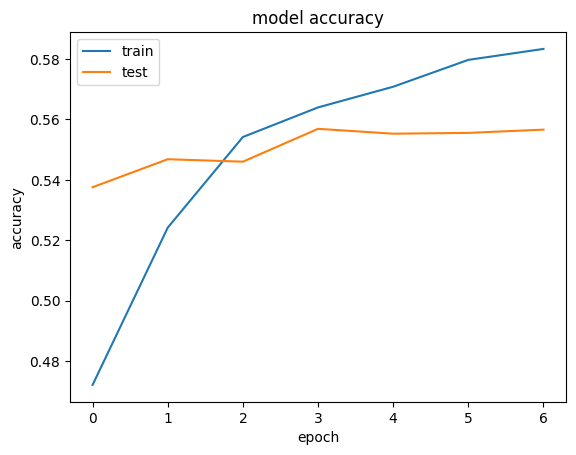

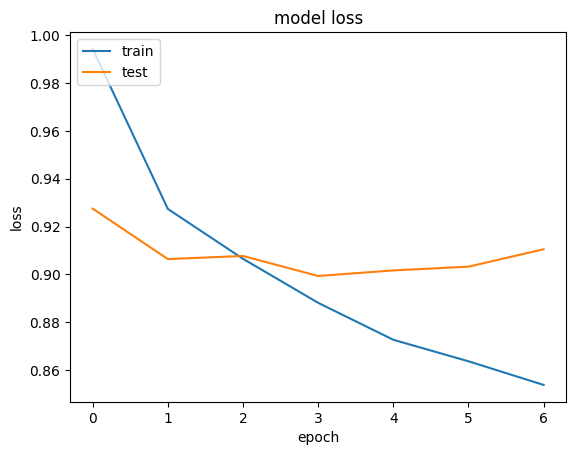

In [40]:

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Second Tunning

In [51]:
def model_builder(hp):
    model = Sequential()
    
    vocabulary_size = 1000
    embedding_size = 50
    max_words = 50  # Assuming you have a max_words variable

    model.add(InputLayer(input_shape=(max_words,)))
    model.add(Embedding(vocabulary_size, embedding_size))

    hp_activation = hp.Choice('activation', values=['relu', 'tanh'])
    hp_units_1 = hp.Int('units_1', min_value=10, max_value=100, step=10)
    hp_units_2 = hp.Int('units_2', min_value=10, max_value=100, step=10)
    #hp_units_3 = hp.Int('units_3', min_value=10, max_value=100, step=10)
    hp_units_4 = hp.Int('units_4', min_value=10, max_value=100, step=10)

    model.add(LSTM(units=hp_units_1, activation=hp_activation, return_sequences=True))
    model.add(LSTM(units=hp_units_2, activation=hp_activation, return_sequences=True))
    # model.add(LSTM(units=hp_units_3, activation=hp_activation, return_sequences=True))
    model.add(LSTM(units=hp_units_4, activation=hp_activation))
    
    model.add(Dense(5, activation='relu'))
    model.add(Dropout(0.2)) 
    model.add(Dense(3, activation='softmax'))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    optimizer = Adam(learning_rate=hp_learning_rate)
    model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

    return model

In [58]:
import keras_tuner as kt

second_tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='dir',
                     project_name='x_2')

In [59]:
stop_early = EarlyStopping(monitor='val_loss', patience=3)
second_tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

Trial 30 Complete [00h 35m 43s]
val_accuracy: 0.5367587804794312

Best val_accuracy So Far: 0.5639925003051758
Total elapsed time: 12h 50m 01s


In [60]:
best_hps_two = second_tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps_two.values

{'activation': 'tanh',
 'units_1': 60,
 'units_2': 100,
 'units_4': 100,
 'learning_rate': 0.001,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 4,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '0013'}

In [61]:
#best_hps.values
# fit the model based on best params
model = second_tuner.hypermodel.build(best_hps_two)
history_two = model.fit(X_train, y_train, epochs=50, validation_split=0.2,
                    callbacks=[stop_early])

Epoch 1/50
  1/932 [..............................] - ETA: 2:37 - loss: 1.0986 - accuracy: 0.2188

/Users/blankajarmoszko/PycharmProjects/Selenium_trial/venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


932/932 [==============================] - 138s 148ms/step - loss: 0.9855 - accuracy: 0.5031 - val_loss: 0.9264 - val_accuracy: 0.5397
Epoch 2/50
932/932 [==============================] - 138s 148ms/step - loss: 0.9214 - accuracy: 0.5439 - val_loss: 0.9160 - val_accuracy: 0.5471
Epoch 3/50
932/932 [==============================] - 136s 146ms/step - loss: 0.9023 - accuracy: 0.5554 - val_loss: 0.9080 - val_accuracy: 0.5476
Epoch 4/50
932/932 [==============================] - 138s 148ms/step - loss: 0.8834 - accuracy: 0.5682 - val_loss: 0.9085 - val_accuracy: 0.5534
Epoch 5/50
932/932 [==============================] - 132s 142ms/step - loss: 0.8707 - accuracy: 0.5717 - val_loss: 0.9015 - val_accuracy: 0.5559
Epoch 6/50
932/932 [==============================] - 131s 141ms/step - loss: 0.8623 - accuracy: 0.5778 - val_loss: 0.9059 - val_accuracy: 0.5559
Epoch 7/50
932/932 [==============================] - 131s 141ms/step - loss: 0.8477 - accuracy: 0.5864 - val_loss: 0.9186 - val_accura

In [62]:
y_pred = np.argmax(model.predict(X_test), axis=1)

print(accuracy_score(y_pred, y_test))
print(confusion_matrix(y_pred, y_test))

y_train_pred = np.argmax(model.predict(X_train), axis=1)
print(accuracy_score(y_train_pred, y_train))

  2/292 [..............................] - ETA: 15s

/Users/blankajarmoszko/PycharmProjects/Selenium_trial/venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


292/292 [==============================] - 15s 53ms/step
0.5609101642159493
[[1735  666  461]
 [ 619 1034  691]
 [ 413 1241 2457]]
   3/1165 [..............................] - ETA: 1:01

/Users/blankajarmoszko/PycharmProjects/Selenium_trial/venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1165/1165 [==============================] - 62s 53ms/step
0.6170709455833423


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


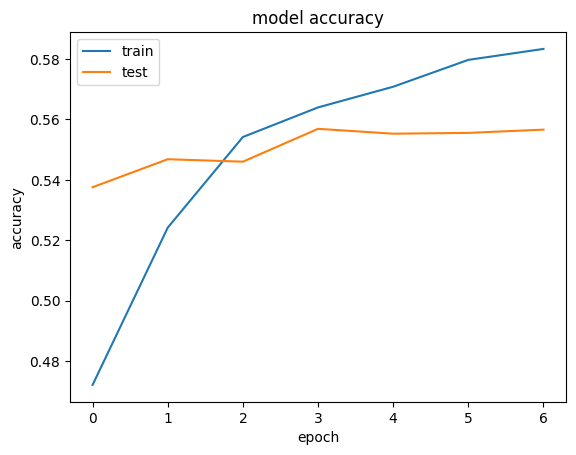

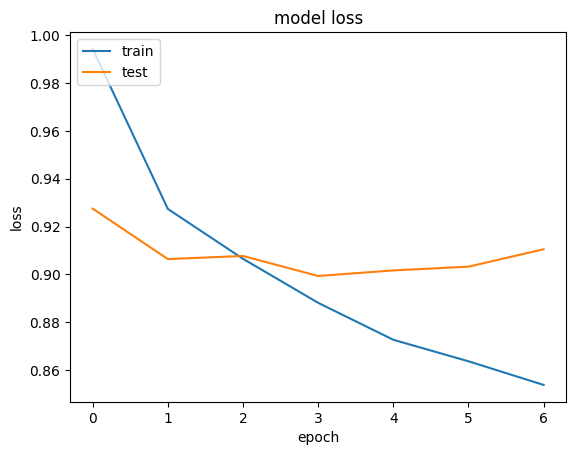

In [63]:

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Dropout
# BERT models
# true classes?
# use clustering for sentiment analysis, look at star distribution
# two class classification
# 
# https://medium.com/@chyun55555/unsupervised-sentiment-analyis-with-sentiwordnet-and-vader-in-python-a519660198be

In [ ]:
# pre trained models for transfer learning